In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import time
from IPython.display import HTML, display

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


In [3]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


### Если у этого есть координаты, почему бы это не посмотреть на карте

In [4]:
import random
# точек очень много, посмотрим по крайней мере на 500 из них
map = folium.Map(location=[40.5,-74], zoom_start = 10)

points = list(zip(data['latitude'], data['longitude']))[:501] 
random.shuffle(points) # взболтать, но не смешивать

for lt, ln in points[0:501]:
    folium.Circle(location=[lt, ln], fill=True, radius=1).add_to(map)
map.save("map.html")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


### Можем наблюдать множество аномальных цен

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

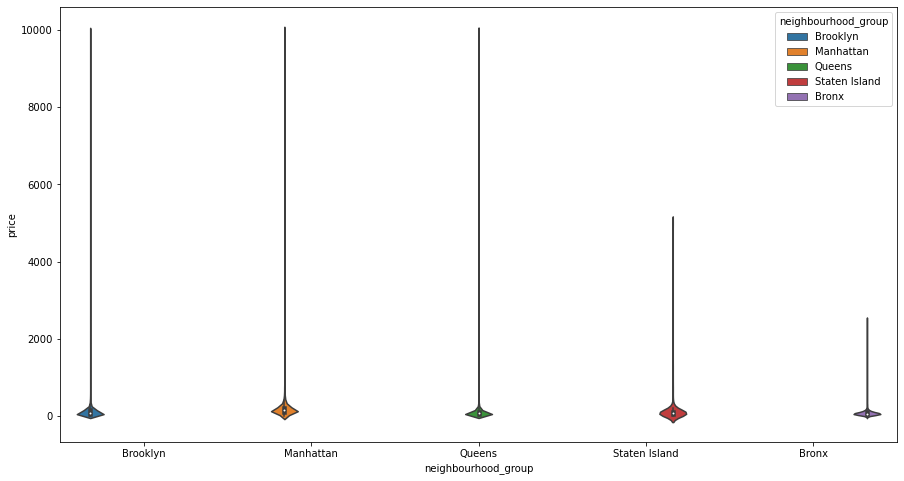

In [6]:
plt.figure(figsize=(15,8))
sns.violinplot(data=data, y='price', x='neighbourhood_group', hue='neighbourhood_group')

### Посмотрим на те, что дешевле 400 долларов

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

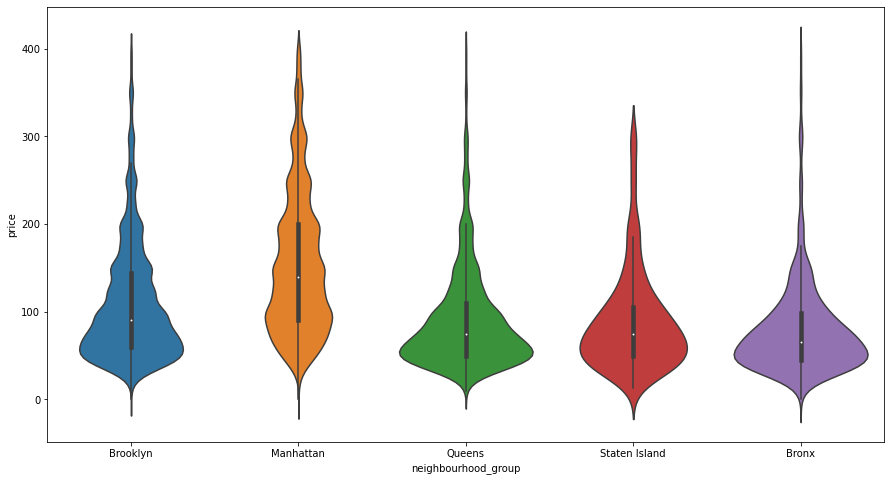

In [7]:
plt.figure(figsize=(15,8))
tmp=data[data['price'] < 400]
sns.violinplot(data=tmp, x='neighbourhood_group', y='price')

In [8]:
price_bins=data.price.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
data['PriceGroups'] = pd.cut(data['price'], price_bins, \
                             labels=[i for i in range(0, 10)], right=True, include_lowest=True)

In [9]:
data.groupby('neighbourhood_group').mean()['price'].sort_values()

neighbourhood_group
Bronx             87.496792
Queens            99.517649
Staten Island    114.812332
Brooklyn         124.383207
Manhattan        196.875814
Name: price, dtype: float64

In [15]:
data.groupby('PriceGroups').price.mean() # цены по квантилям

PriceGroups
0     39.425502
1     55.088562
2     69.511767
3     84.182326
4     99.002405
5    120.022180
6    145.762742
7    182.817964
8    236.468910
9    517.171382
Name: price, dtype: float64

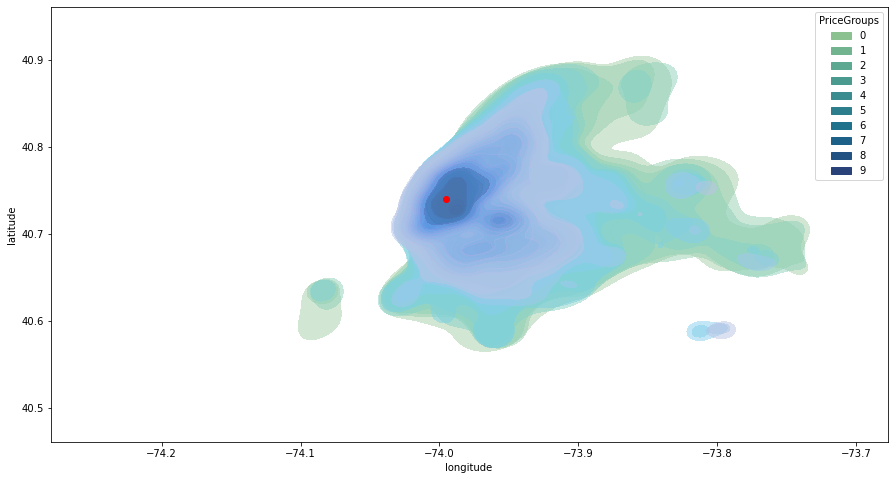

In [32]:
plt.figure(figsize=(15,8))
sns.kdeplot(x=data['longitude'], y=data['latitude'], hue=data['PriceGroups'], palette="crest", fill=True, alpha=0.5)

plt.scatter(-73.995, 40.74, color='red') 
# возьмём данную точку, для расчёта удаленности жилья от неё

In [61]:
# самое что ни на есть манхэттенское расстояние (в градусах, без учёта преград, дорог и т.д.)
data['dist_to_center'] = abs(data['longitude'] + 73.995) + abs(data['latitude'] - 40.74)

In [49]:
regions = data.groupby('neighbourhood_group').mean()['price'].sort_values().index.to_list()
room_types = data['room_type'].unique()

### Nan в reviews_per_month заполним средним по квантилям

In [21]:
data.reviews_per_month = data.groupby(['PriceGroups']).reviews_per_month.transform(lambda x: x.fillna(x.mean())).round(0)

### Перекодируем районы по принципу Ordinary Encode по мере увеличения средней стоимости жилья

In [12]:
encoded_regions = {val:i+1 for i, val in enumerate(regions)}
encoded_room_t =  {val:i+1 for i, val in enumerate(room_types)}

data = data.replace({'neighbourhood_group':encoded_regions})
data = data.replace({'room_type':encoded_room_t})

### Попробуем перекодировать более мелкие районы (neighbourhood) CountEncoder'ом, таким образом для каждого neighbourhood будет своего рода плотность предложений

In [24]:
from category_encoders import CountEncoder

def encode_func(data, enc, cols):
    data_enc = data.copy()
    data_enc[cols]= enc.fit_transform(data_enc[cols])
    return data_enc

enc = CountEncoder()
data = encode_func(data, enc, cols = ['neighbourhood'])
data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,PriceGroups
0,4,175,40.64749,-73.97237,1,149,1,9,0.0,6,365,6
1,5,1545,40.75362,-73.98377,2,225,1,45,0.0,2,355,8
2,5,2658,40.80902,-73.94190,1,150,3,0,1.0,1,365,6
3,4,572,40.68514,-73.95976,2,89,1,270,5.0,1,194,3
4,5,1117,40.79851,-73.94399,2,80,10,9,0.0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,4,3714,40.67853,-73.94995,1,70,2,0,1.0,2,9,2
48891,4,2465,40.70184,-73.93317,1,40,4,0,1.0,2,36,0
48892,5,2658,40.81475,-73.94867,2,115,10,0,1.0,1,27,5
48893,5,1958,40.75751,-73.99112,3,55,1,0,2.0,6,2,1
